# CSE 256 Project
## baseline model
### Specific: LSTM

In [1]:
!pip install -U torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [2]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


## Standford Stentiment Treebank Data Preparing and Data Processing

In [3]:
# import libraries that will help us preprocess data, map to word embeddings
import torchtext
from torchtext.vocab import Vectors, GloVe

In [4]:
print(torch.__version__)

2.0.1+cu118


In [5]:
print(torchtext.__version__)

0.6.0


In [6]:
# this will be our input x to the classifiers
TEXT = torchtext.data.Field()

# this will be what we map to, the tag y
LABEL = torchtext.data.Field(sequential=False, dtype=torch.long)

In [7]:
# split the dataset into train, val, and test sets. Exclude neutral labels, so just positive or negative
train, val, test = torchtext.datasets.SST.splits(TEXT, LABEL, filter_pred=lambda ex: ex.label != 'neutral', fine_grained=True, train_subtrees=False)

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:00<00:00, 4.48MB/s]


extracting


In [8]:
# each consists of a label and it's original words
print('len(train)', len(train))
print('vars(train[0])', vars(train[0]))

len(train) 6920
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}


In [10]:
# assign an index to each word and label (unique) kind of like countvectorizer
TEXT.build_vocab(train)
LABEL.build_vocab(train)
print('len(text_cnn.vocab)', len(TEXT.vocab))
print('len(label_cnn.vocab)', len(LABEL.vocab))

len(text_cnn.vocab) 16284
len(label_cnn.vocab) 5


In [11]:
# produce three batch iterators that iterate 10 examples at a time
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1)

In [12]:
# Build the vocabulary with word embeddings
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

print("Word embeddings size ", TEXT.vocab.vectors.size())
print("Word embedding of 'follows', first 10 dim ", TEXT.vocab.vectors[TEXT.vocab.stoi['follows']][:10])

.vector_cache/wiki.simple.vec: 293MB [00:02, 144MB/s]                           
100%|██████████| 111051/111051 [00:13<00:00, 8395.06it/s]


Word embeddings size  torch.Size([16284, 300])
Word embedding of 'follows', first 10 dim  tensor([ 0.3925, -0.4770,  0.1754, -0.0845,  0.1396,  0.3722, -0.0878, -0.2398,
         0.0367,  0.2800])


In [13]:
# Get pretrained embeddings, dimensions, and training parameters
pretrained_embeddings = TEXT.vocab.vectors
input_dim = len(TEXT.vocab)
emb_dim = pretrained_embeddings.shape[1]
train_iterations = len(train_iter)
val_iterations = len(val_iter)

In [14]:
#import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torchtext.vocab import CharNGram, FastText

In [15]:
#Define network architecture
class net(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded)
        output = torch.nn.functional.dropout(output, p=0.5)
        return self.fc(output[-1])

In [16]:
# Hyperparameters
num_layers = 2
hidden_dim = 768
output_dim = 5
num_epochs = 10
learning_rate = 0.0001
disp_freq = 20

In [17]:
# Define model, optimizer, and criterion
model = net(input_dim, emb_dim, hidden_dim, output_dim, num_layers)
model.embedding.weight.data.copy_(pretrained_embeddings)
opitmizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

In [18]:
# Training
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []
for epoch in range(num_epochs):
    model.train()
    for i, batch in enumerate(train_iter):
        label = batch.label.sub(1)
        opitmizer.zero_grad()
        predictions = model(batch.text).squeeze(1)

        # Process training loss
        loss = criterion(predictions, label)
        training_loss.append(loss.item())

        # Process training accuracy
        correct = (predictions.argmax(dim=1) == label).float()
        accuracy = correct.sum()/len(correct)
        training_accuracy.append(accuracy.item())

        loss.backward()
        opitmizer.step()
        if (i+1) % disp_freq == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, i+1, train_iterations, loss.item(), accuracy.item()))

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch in val_iter:
            label = batch.label.sub(1)
            predictions = model(batch.text.squeeze(1))

            # Process validation loss
            loss = criterion(predictions, label)
            validation_loss.append(loss.item())
            epoch_loss = epoch_loss + loss

            # Process validation accuracy
            correct = (predictions.argmax(dim=1) == label).float()
            accuracy = correct.sum()/len(correct)
            validation_accuracy.append(accuracy.item())
            epoch_accuracy = epoch_accuracy + accuracy

    print("**********************************************************************************************************")
    print ('VALIDATION FOR EPOCH {}/{} --> Average Loss: {:.4f}, Average Accuracy: {:.4f}'.format(epoch+1, num_epochs, epoch_loss/val_iterations, epoch_accuracy/val_iterations))
    print("**********************************************************************************************************")

Epoch [1/10], Step [20/692], Loss: 1.5216, Accuracy: 0.4000
Epoch [1/10], Step [40/692], Loss: 1.2668, Accuracy: 0.5000
Epoch [1/10], Step [60/692], Loss: 1.2576, Accuracy: 0.4000
Epoch [1/10], Step [80/692], Loss: 1.3840, Accuracy: 0.2000
Epoch [1/10], Step [100/692], Loss: 1.5169, Accuracy: 0.2000
Epoch [1/10], Step [120/692], Loss: 1.4360, Accuracy: 0.4000
Epoch [1/10], Step [140/692], Loss: 1.5509, Accuracy: 0.2000
Epoch [1/10], Step [160/692], Loss: 1.2429, Accuracy: 0.5000
Epoch [1/10], Step [180/692], Loss: 1.3128, Accuracy: 0.3000
Epoch [1/10], Step [200/692], Loss: 1.2732, Accuracy: 0.3000
Epoch [1/10], Step [220/692], Loss: 1.3202, Accuracy: 0.4000
Epoch [1/10], Step [240/692], Loss: 1.3060, Accuracy: 0.3000
Epoch [1/10], Step [260/692], Loss: 1.4333, Accuracy: 0.3000
Epoch [1/10], Step [280/692], Loss: 1.3120, Accuracy: 0.6000
Epoch [1/10], Step [300/692], Loss: 1.1422, Accuracy: 0.4000
Epoch [1/10], Step [320/692], Loss: 1.2652, Accuracy: 0.5000
Epoch [1/10], Step [340/692]

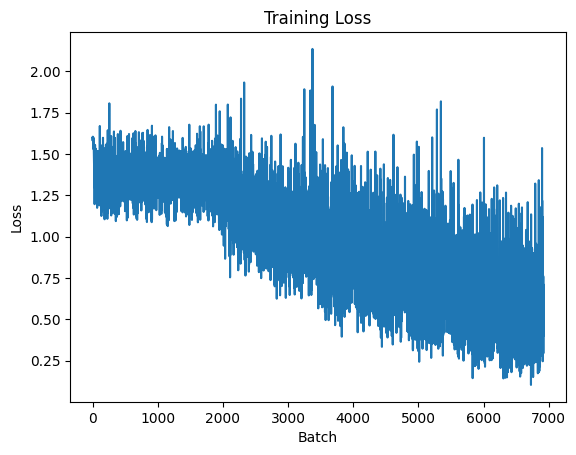

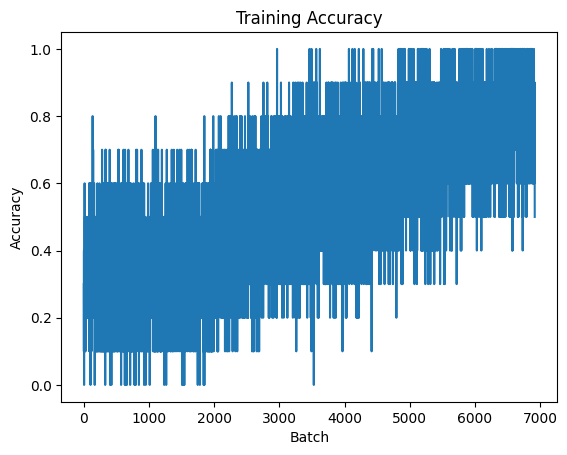

In [19]:
# Plot training loss and accuracy
fig = plt.figure()
plt.plot(training_loss)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()
fig = plt.figure()
plt.plot(training_accuracy)
plt.title("Training Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

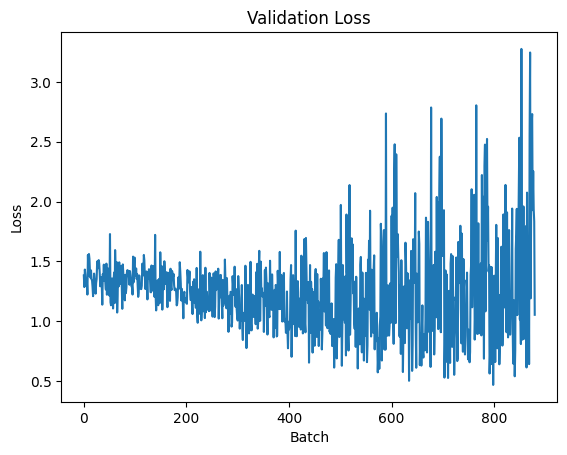

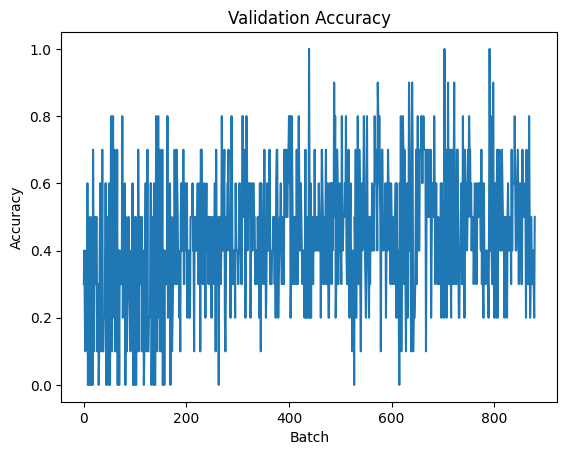

In [20]:
# Plot validation loss and accuracy
fig = plt.figure()
plt.plot(validation_loss)
plt.title("Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()
fig = plt.figure()
plt.plot(validation_accuracy)
plt.title("Validation Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

In [21]:
predictions.size()

torch.Size([2, 5])

In [22]:
predictions

tensor([[  0.5629,   1.9880,  -1.3556,  -0.0287, -11.9690],
        [  3.4104,  -3.4489,   4.3102,  -3.9707, -10.9313]])

In [23]:
label

tensor([0, 2])

In [24]:
criterion(predictions, label)

tensor(1.0548)

In [78]:
# Testing
testing_loss = 0
testing_accuracy = 0
average_testing_loss = 0
average_testing_accuracy = 0
model.eval()
with torch.no_grad():
    for batch in test_iter:
        label = batch.label.sub(1)
        predictions = model(batch.text.squeeze(1))
        # Process testing loss
        loss = criterion(predictions.view(int(predictions.size().numel()/5),5), label)
        testing_loss = testing_loss + loss.item()

        # Process testing accuracy
        correct = (predictions.view(int(predictions.size().numel()/5),5).argmax(dim=1) == label).float()
        accuracy = correct.sum()/len(correct)
        testing_accuracy = testing_accuracy + accuracy.item()


    average_testing_loss = testing_loss/len(test_iter)
    average_testing_accuracy  = (testing_accuracy/len(test_iter))*100

print('Average testing loss: {:.4f}, Average testing accuracy: {:.2f}%'.format(average_testing_loss, average_testing_accuracy))


Average testing loss: 1.3009, Average testing accuracy: 51.75%
